In [40]:
import os
import warnings

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [41]:
# 预设值
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None  # 展示所有列

In [42]:
# 初始数据
RAW_TRAIN = './datasets/serverless/total.csv'

## 1. 加载数据

In [43]:
# 加载原始数据
train_df = pd.read_csv(RAW_TRAIN)
train_df = train_df.sort_values(by=['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)
display(train_df)

,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LAUNCHING_JOB_NUMS,RUNNING_JOB_NUMS,SUCCEED_JOB_NUMS,CANCELLED_JOB_NUMS,FAILED_JOB_NUMS,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE
0,2,16,available,sql,x86_64,3,54,0,0,0,0,0,1590683100000,vm,20.0
1,2,16,available,sql,x86_64,2,54,0,0,0,0,0,1590683400000,vm,20.0
2,2,16,available,sql,x86_64,7,54,0,0,0,0,0,1590683700000,vm,20.0
3,2,16,available,sql,x86_64,4,54,0,0,0,0,0,1590684000000,vm,20.0
4,2,16,available,sql,x86_64,5,54,0,0,0,0,0,1590684120000,vm,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501725,87139,16,available,general,x86_64,3,36,0,0,0,0,0,1599867000000,vm,26.0
501726,87139,16,available,general,x86_64,2,36,0,0,0,0,0,1599867420000,vm,26.0
501727,87139,16,available,general,x86_64,3,36,0,0,0,0,0,1599867840000,vm,26.0
501728,87139,16,available,general,x86_64,2,36,0,0,0,0,0,1599868260000,vm,26.0


## 2. 数据预处理

In [44]:
def digitalization(fields):
    """将非数值型域转换为数值型."""

    for f in fields:
        # 构建编码器
        le = LabelEncoder()
        le.fit(train_df[f])

        # 设置新值
        train_df[f] = le.transform(train_df[f])
        print('%s:' % f, le.classes_)


def pre_processing():
    """预处理."""
    print('Preprocessing...')

    # 缺失值填充
    # 经检验，为NaN的都是vm（通过QUEUE_ID查找）
    train_df['RESOURCE_TYPE'].fillna('vm', inplace=True)

    # 观察数据，填充0比较合理（NaN集中在数据前面，可能是由服务器尚未开始运行导致的）
    train_df['DISK_USAGE'].fillna(0, inplace=True)

    # 需要转换的列
    fields = ['STATUS', 'QUEUE_TYPE', 'PLATFORM', 'RESOURCE_TYPE']

    # 数值化
    digitalization(fields)

    # 重命名，原来的名字太长了
    train_df.rename(columns={
        'LAUNCHING_JOB_NUMS': 'LJOB',
        'RUNNING_JOB_NUMS': 'RJOB',
        'SUCCEED_JOB_NUMS': 'SJOB',
        'CANCELLED_JOB_NUMS': 'CJOB',
        'FAILED_JOB_NUMS': 'FJOB'
    }, inplace=True)

In [45]:
%%time
pre_processing()

train_df = train_df.sort_values(by=['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)
display(train_df)

Preprocessing...
STATUS: ['assigned' 'assigning' 'available' 'suspended']
QUEUE_TYPE: ['general' 'spark' 'sql']
PLATFORM: ['aarch64' 'x86_64']
RESOURCE_TYPE: ['container' 'vm']


,QUEUE_ID,CU,STATUS,QUEUE_TYPE,PLATFORM,CPU_USAGE,MEM_USAGE,LJOB,RJOB,SJOB,CJOB,FJOB,DOTTING_TIME,RESOURCE_TYPE,DISK_USAGE
0,2,16,2,2,1,3,54,0,0,0,0,0,1590683100000,1,20.0
1,2,16,2,2,1,2,54,0,0,0,0,0,1590683400000,1,20.0
2,2,16,2,2,1,7,54,0,0,0,0,0,1590683700000,1,20.0
3,2,16,2,2,1,4,54,0,0,0,0,0,1590684000000,1,20.0
4,2,16,2,2,1,5,54,0,0,0,0,0,1590684120000,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501725,87139,16,2,0,1,3,36,0,0,0,0,0,1599867000000,1,26.0
501726,87139,16,2,0,1,2,36,0,0,0,0,0,1599867420000,1,26.0
501727,87139,16,2,0,1,3,36,0,0,0,0,0,1599867840000,1,26.0
501728,87139,16,2,0,1,2,36,0,0,0,0,0,1599868260000,1,26.0


CPU times: total: 15.6 ms
Wall time: 413 ms


## 3. 降噪

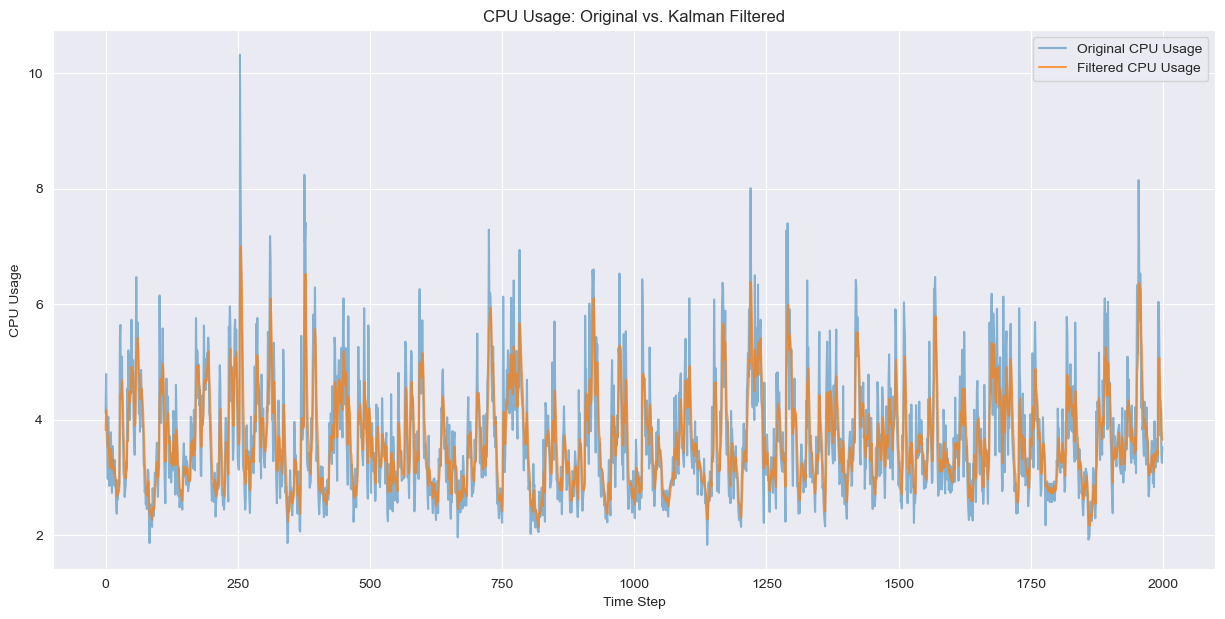

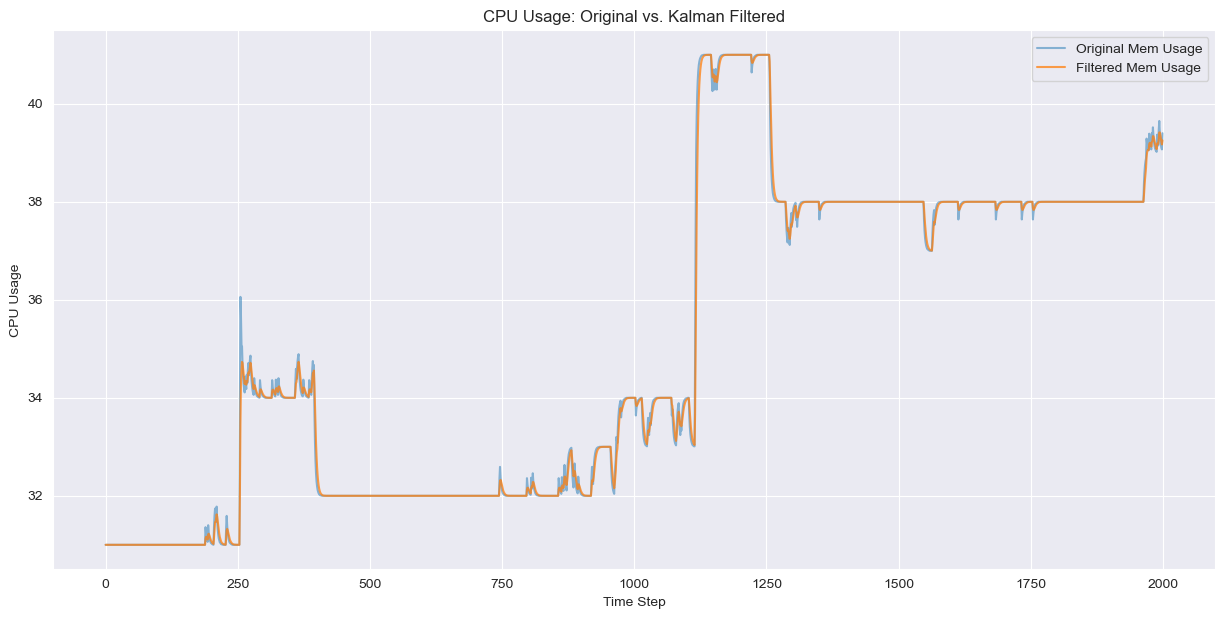

In [52]:
# 去噪
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

train_df = train_df[train_df['QUEUE_ID'].isin([2, 3, 4, 36, 291, 84907])]

# 初始化卡尔曼滤波器参数
initial_state_mean = train_df['CPU_USAGE'][0]
observation_covariance = train_df['CPU_USAGE'].var()  # 观测噪声
transition_covariance = np.var(train_df['CPU_USAGE']) / 5  # 过程噪声，假设较小
transition_matrices = [1]  # 状态转移矩阵
observation_matrices = [1]  # 观测矩阵

# 初始化卡尔曼滤波器
kf = KalmanFilter(
    initial_state_mean=initial_state_mean,
    initial_state_covariance=observation_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    transition_matrices=transition_matrices,
    observation_matrices=observation_matrices
)

# 应用简单卡尔曼滤波器进行去噪
cpu_usage = train_df['CPU_USAGE'].values
cpu_usage = cpu_usage
cpu_usage_mean = np.mean(cpu_usage)
cpu_usage_std = np.std(cpu_usage)
cpu_usage_z_score = (cpu_usage - cpu_usage_mean) / cpu_usage_std

mem_usage = train_df['MEM_USAGE'].values
mem_usage = mem_usage
mem_usage_mean = np.mean(mem_usage)
mem_usage_std = np.std(mem_usage)
mem_usage_z_score = (mem_usage - mem_usage_mean) / mem_usage_std

# 使用卡尔曼滤波器对CPU_USAGE去噪
cpu_means, _ = kf.filter(cpu_usage)
mem_means, _ = kf.filter(mem_usage)

# 绘制去噪前后的对比时序图
plt.figure(figsize=(15, 7))
plt.plot(cpu_usage[3000:5000], label='Original CPU Usage', alpha=0.5)
plt.plot(cpu_means[3000:5000], label='Filtered CPU Usage', alpha=0.75)
plt.title('CPU Usage: Original vs. Kalman Filtered')
plt.xlabel('Time Step')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(mem_usage[3000:5000], label='Original Mem Usage', alpha=0.5)
plt.plot(mem_means[3000:5000], label='Filtered Mem Usage', alpha=0.75)
plt.title('CPU Usage: Original vs. Kalman Filtered')
plt.xlabel('Time Step')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# 将state_means
train_df['CPU_USAGE'] = cpu_means
train_df['MEM_USAGE'] = mem_means

train_df['CPU_USAGE'] = train_df['CPU_USAGE'].round(2)
train_df['MEM_USAGE'] = train_df['MEM_USAGE'].round(2)

3.5255


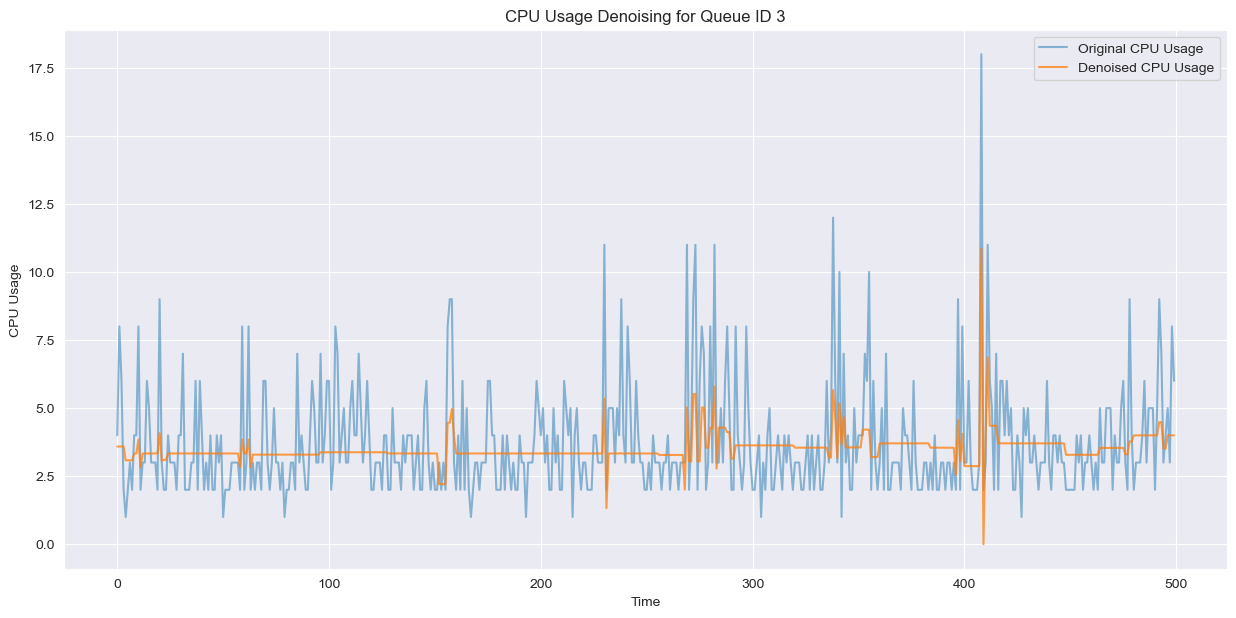

In [11]:
import pywt
import pandas as pd

# 假设df是你的数据集，其中包含CPU_USAGE列
# 这里使用上述数据集作为示例，你可以根据需要调整列名和数据选择

# 选择一个队列的CPU使用率数据进行降噪
queue_id = 3  # 示例队列ID
cpu_usage_data = train_df[train_df['QUEUE_ID'] == queue_id]['CPU_USAGE'].values
# cpu_usage_data = train_df['CPU_USAGE'].values
cpu_usage_data = cpu_usage_data[0:500]

# 使用小波变换进行多级分解
coeffs = pywt.wavedec(cpu_usage_data, 'db1', mode='symmetric', level=None)

N = len(cpu_usage_data)
# 设置阈值进行噪声去除
threshold = round(np.sqrt(2 * np.log(N)), 4)  #阈值获取，方式为sqtwolog

# 计算通用阈值
# sigma = np.median(np.abs(coeffs[-1])) / 0.6745
# print(sigma)
# threshold = sigma * np.sqrt(2 * np.log(N))
print(threshold)

coeffs_thresholded = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs]

# 使用阈值处理后的系数进行重构
cpu_usage_denoised = pywt.waverec(coeffs_thresholded, 'db1')
# 对降噪后的数据进行0-100之间的值处理
cpu_usage_denoised = np.clip(cpu_usage_denoised, 0, 100)

plt.figure(figsize=(15, 7))
plt.plot(cpu_usage_data, label='Original CPU Usage', alpha=0.5)
plt.plot(cpu_usage_denoised, label='Denoised CPU Usage', alpha=0.75)
plt.legend()
plt.title(f'CPU Usage Denoising for Queue ID {queue_id}')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.show()

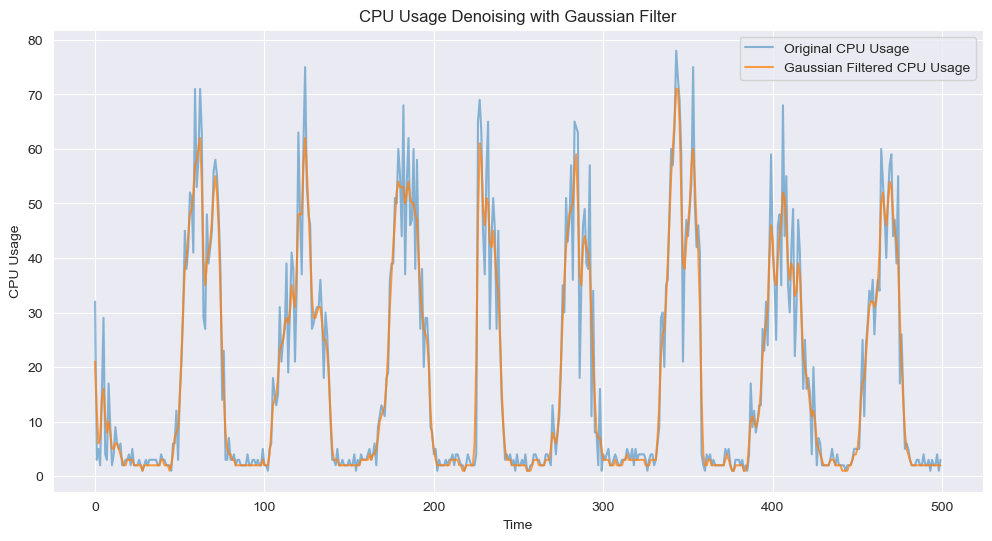

In [10]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# 假设cpu_usage_data是你想要降噪的CPU使用率数据
queue_id = 36  # 示例队列ID
cpu_usage_data = train_df[train_df['QUEUE_ID'] == queue_id]['CPU_USAGE'].values
# cpu_usage_data = train_df['CPU_USAGE'].values
cpu_usage_data = cpu_usage_data[0:500]

# 应用高斯滤波降噪
sigma = 1  # 高斯核的标准差，调整此值以改变平滑程度
cpu_usage_denoised = gaussian_filter1d(cpu_usage_data, sigma)

# 绘图比较原始数据和降噪后的数据
plt.figure(figsize=(12, 6))
plt.plot(cpu_usage_data, label='Original CPU Usage', alpha=0.5)
plt.plot(cpu_usage_denoised, label='Gaussian Filtered CPU Usage', alpha=0.75)
plt.legend()
plt.title('CPU Usage Denoising with Gaussian Filter')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.show()


## 4. 导出数据

In [54]:
train_df.set_index('DOTTING_TIME', inplace=True)

train_df.drop(['STATUS', 'PLATFORM', 'RESOURCE_TYPE', 'DISK_USAGE', 'SJOB', 'CJOB', 'FJOB'], axis=1,
              inplace=True)
# 调整顺序
new_order = ['CPU_USAGE', 'QUEUE_ID', 'CU', 'QUEUE_TYPE', 'MEM_USAGE', 'LJOB', 'RJOB']
train_df = train_df[new_order]

# 删除不必要的队列（由EDA分析后，完全没规律，无法学习）
queue_ids_to_remove = queues = [2, 3, 4, 36, 291]
train_df = train_df[train_df['QUEUE_ID'].isin(queue_ids_to_remove)]

# 七个特征
print(train_df)
# 输出处理好的数据集
train_df.to_csv('./datasets/serverless/data.csv', encoding="utf-8", index=True,
                index_label="timestamp")

               CPU_USAGE  QUEUE_ID    CU  QUEUE_TYPE  MEM_USAGE  LJOB  RJOB
DOTTING_TIME                                                               
1590683100000       3.00         2    16           2      15.75     0     0
1590683400000       2.83         2    16           2      25.32     0     0
1590683700000       3.37         2    16           2      32.67     0     0
1590684000000       3.67         2    16           2      38.34     0     0
1590684120000       3.96         2    16           2      42.64     0     0
...                  ...       ...   ...         ...        ...   ...   ...
1598744220000      88.27       291  1024           2      31.00     0     4
1598744520000      82.10       291  1024           2      31.00     0     2
1598744820000      69.15       291  1024           2      31.00     0     0
1598745120000      54.94       291  1024           2      31.00     0     0
1598745480000      42.04       291  1024           2      31.00     0     0

[69895 rows

In [55]:
# 查看每个queue_id对应有多少数据
q_ids = train_df['QUEUE_ID'].value_counts().sort_index()
display(q_ids)
q_ids.to_csv('./datasets/serverless/q_ids.csv', encoding="utf-8", index=True)

QUEUE_ID
2      19255
3      19257
4      19257
36      3242
291     8884
Name: count, dtype: int64

In [56]:
# Load the provided file
queue_ids_df = pd.read_csv('./datasets/serverless/q_ids.csv')

start = 0
ranges_start = []
ranges_end = []
for index, row in queue_ids_df.iterrows():
    end = start + row['count'] - 1
    ranges_start.append(start)
    ranges_end.append(end)
    start = end + 1

# Add the range column to the dataframe
queue_ids_df['ranges_start'] = ranges_start
queue_ids_df['ranges_end'] = ranges_end
queue_ids_df.head()
queue_ids_df.to_csv('./datasets/serverless/q_ids.csv', encoding="utf-8", index=True, index_label='id')

In [59]:
queue_ids_df = pd.read_csv('./datasets/serverless/q_ids.csv')
display(queue_ids_df)
print(queue_ids_df['range'][0])

,id,QUEUE_ID,count,ranges_start,ranges_end
0,0,2,19255,0,19254
1,1,3,19257,19255,38511
2,2,4,19257,38512,57768
3,3,36,3242,57769,61010
4,4,291,8884,61011,69894


KeyError: 'range'

In [ ]:
# 根据EDA分析，我选了几个感觉可以训练的QUEUE
queues = [2, 3, 4, 27, 36, 291, 85153, 85693]
for queue_id in tqdm(queues):
    queue_df = train_df[train_df.QUEUE_ID == queue_id]
    # 删除原有的index列，换成时间列
    # queue_df.set_index('DOTTING_TIME', inplace=True)
    # 将处理好的数据导出到本地
    queue_df.to_csv('./datasets/serverless/cached/queue_id_%d.csv' % queue_id, encoding="utf-8", index=True,
                    index_label="timestamp")

In [ ]:
for queue_id in tqdm(q_ids):
    queue_df = train_df[train_df.QUEUE_ID == queue_id]
    queue_df.to_csv('./datasets/serverless/cached/queue_id_%d.csv' % queue_id, encoding="utf-8", index=True,
                    index_label="timestamp")